# <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> EE 046202 - Technion - Unsupervised Learning & Data Analysis
---

## Computer Assignment 2 - Variational Autoencoders & Clustering
---

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* Variational Autoencoders (VAEs)
    * $\beta$-VAE
    * Conditional VAE (CVAE)
    * BONUS: Generating Pokemons
* Clustering

#### Use as many cells as you need
#### אפשר גם לכתוב בעברית, אבל עדיף באנגלית

* Code Tasks are denoted with: <img src="https://img.icons8.com/color/48/000000/code.png">
* Questions (which you need to answer in a Markdown cell) are denoted with: <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png">

### <img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline"> Students Information
---
* Fill in

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Yuval Goshen| yuval.goshen@campus.technion.ac.il| 205810179|
|Dor Bitton| dor.bitton@campus.technion.ac.il| 205888324|

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
* Maximal garde: **100** (even with the bonus, the grade will not be above 100).
    * Example: if you got 5 points bonus, but you were right in all sections, your grade will still be 100 (and not 105).
    * Example: if you got 5 points bonus, and 6 points were deducted for wrong answers, your grade will be 99.
* Submission only in **pairs**. 
    * Please make sure you have registered your group in Moodle (there is a group creation component on the Moodle where you need to create your group and assign members).
* **BONUS**:
    * 5 points - completing the Pokemon task with *fully-connected* layers (black & white version)
    * 10 points - completing the Pokemon task with *convolutional* layers (RGB version)
* **No handwritten submissions.** You can choose whether to answer in a Markdown cell in this notebook or attach a PDF with your answers.
* <a style='color:red'> SAVE THE NOTEBOOKS WITH THE OUTPUT, CODE CELLS THAT WERE NOT RUN WILL NOT GET ANY POINTS! </a>
* What you have to submit:
    * If you have answered the questions in the notebook, you should submit this file only, with the name: `ee046202_wet2_id1_id2.ipynb`.
    * If you answered the questions in a different file you should submit a `.zip` file with the name `ee046202_wet2_id1_id2.zip` with content:
        * `ee046202_wet2_id1_id2.ipynb` - the code tasks
        * `ee046202_wet2_id1_id2.pdf` - answers to questions.
    * No other file-types (`.py`, `.docx`...) will be accepted.
* Submission on the course website (Moodle).
* **Latex in Colab** - in some cases, Latex equations may no be rendered. To avoid this, make sure to not use *bullets* in your answers ("* some text here with Latex equations" -> "some text here with Latex equations").

### <img src="https://img.icons8.com/clouds/96/000000/keyboard.png" style="height:50px;display:inline"> Keyboard Shortcuts
---
* Run current cell: **Ctrl + Enter**
* Run current cell and move to the next: **Shift + Enter**
* Show lines in a code cell: **Esc + L**
* View function documentation: **Shift + Tab** inside the parenthesis or `help(name_of_module)`
* New cell below: **Esc + B**
* Delete cell: **Esc + D, D** (two D's)

### <img src="https://img.icons8.com/cute-clipart/64/000000/info.png" style="height:50px;display:inline"> Tip
---
If you find it more convenient, you can copy the section to a new cell, and answer the question or rite the code just right below it. For example:

#### Question 0
1. What is the best course in the Technion?
2. Why does no one pick Bulbasaur as first pokemon?
3. Why is there no superhero named Catman?

#### Answers - Q0

#### Q0 - Section 1
* Q: What is the best course in the Technion?

In [2]:
print("ANAM!")

ANAM!


#### Q0 - Section 2
* Q: Why does no one pick Bulbasaur as first pokemon?

It is really a riddle....

#### Q0 - Section 3
* Q: Why is there no superhero named Catman?

I got nothing.

### <img src="https://img.icons8.com/cotton/64/000000/grand-master-key.png" style="height:50px;display:inline"> Part 1 - Variational Autoencoders - Prologue
---
In this section of the exercise we will analyze the VAE and introduce an enhacement called $\beta$-VAE and also a variation of VAE that allows us some control over the latent space using conditional probability - Conditional Variational Autoencoder.

For this part, you are provided the original implementation of the VAE from the tutorial. You will have to modify it throughout the tasks (yes yes, you can copy-paste from the original implementation).
* **Note** - for better results you should tune the model!
    * You can add layers / hidden units / different activations (ReLU, TanH, LeakyReLU, Sigmoid...)
    * You can choose a different optimizer than Adam (SGD, RMSProp...), tune the learning rate...
    * You can change the reconstruction loss (BCE, MSE, L1...)
    * Other hyper-parameters like the batch-size, number of epochs and etc...

We recommend running this part on Google Colab or on a GPU (if you have an access to one). Note that running on a GPU will lead to about x2 speedup in training. 

In [1]:
# imports for the exrcise - part 1
# you can add more if you wish (but it is not really needed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision

In [2]:
# the original implementation from the tutorial - leave untouched (for your own sake), copy-paste what you need to another cell

# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variance of x
    :param device: device to perform calculations on
    :return z: the sampled latent variable
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std


# encoder - Q(z|X)
class VaeEncoder(torch.nn.Module):
    """
       This class builds the encoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       :param device: cpu or gpu
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10, device=torch.device("cpu")):
        super(VaeEncoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.device = device
        
        self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                      nn.ReLU())
        
        self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output mu
        self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output logvar


    def bottleneck(self, h):
        """
        This function takes features from the encoder and outputs mu, log-var and a latent space vector z
        :param h: features from the encoder
        :return: z, mu, log-variance
        """
        mu, logvar = self.fc1(h), self.fc2(h)
        # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        z, mu, logvar = VaeEncoder(X)
        """
        h = self.features(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    
class VaeDecoder(torch.nn.Module):
    """
       This class builds the decoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10):
        super(VaeDecoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.x_dim),
                                     nn.Sigmoid())
        # why we use sigmoid? becaue the pixel values of images are in [0,1] and sigmoid(x) does just that!
        # if you don't work with images, you don't have to use that.


    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        x_reconstruction = VaeDecoder(z)
        """
        x = self.decoder(x)
        return x
    

class Vae(torch.nn.Module):
    def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu")):
        super(Vae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

    def encode(self, x):
        z, mu, logvar = self.encoder(x)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x

    def sample(self, num_samples=1):
        """
        This functions generates new data by sampling random variables and decoding them.
        Vae.sample() actually generatess new data!
        Sample z ~ N(0,1)
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        return self.decode(z)

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z
    

def loss_function(recon_x, x, mu, logvar, loss_type='bce'):
    """
    This function calculates the loss of the VAE.
    loss = reconstruction_loss - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param recon_x: the reconstruction from the decoder
    :param x: the original input
    :param mu: the mean given X, from the encoder
    :param logvar: the log-variance given X, from the encoder
    :param loss_type: type of loss function - 'mse', 'l1', 'bce'
    :return: VAE loss
    """
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_error + kl) / x.size(0)

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 1 - $\beta$-VAE
---
In the standard VAE an isotropic Gaussian ($p(z) \sim \mathcal{N}(0, I)$) is typically assumed as the prior distribution for z. Note that under this distribution the components of z are independent (e.g. disentangled - a disentangled representation can be defined as one where single latent units are sensitive to changes in single generative factors, while being relatively invariant to changes in other factors) which is exactly the property we would like our approximate posterior distribution (e.g. $q(z|x)$) to have. Thus, to encourage independence we increase the KL-divergence term in the ELBO by a factor of $\beta$: $$ \mathcal{L}_{\beta-VAE} = -\mathbb{E}_{q_{\phi(z|x)}}[p_{\theta}(x|z)] + \beta \cdot D_{KL}[q_{\theta}(z|x) || p(z)]  $$
   * Training is performed exactly the same as for the standard VAE.
   * When $\beta=1$, it is same as VAE.
   * When $\beta>1$, it applies a stronger constraint on the latent bottleneck and limits the representation capacity of $z$. 
       * For some conditionally independent generative factors, keeping them disentangled is the most efficient representation.
   * When $0<\beta<1$, it can be interpreted as optimizing an approximate log marginal likelihood bound under an alternative prior, regularized to prevent degeneracy (of the KL-divergence).
   
The tasks:
1. Modify the loss function to support $\beta$-VAE. The function should return the reconstruction loss, the kl-divergence (**without the multiplication by $\beta$**) and and the total loss.
    * The signature of the function should be: `beta_loss_function(recon_x, x, mu, logvar, loss_type='bce', beta=1)`
    * The reconstruction loss, the kl-divergence and and the total loss should be normalzied by the batch size.
    * The returned reconstruction loss and kl-divergence should be converted to numpy: `kl_d.data.cpu().numpy()` (but only them, not the total loss)
2. Load the MNIST dataset, as in the tutorial, and create a train loader.
3. For $\beta=[0.05, 0.5, 1, 5]$, train a $\beta$-VAE for 50 epochs and keep track of:
    * The average reconstruction loss in each epoch
    * The average KL-divergence in each epoch
    * A checkpoint of the network in the format: `beta_(value of beta)_vae_50_epochs.pth` (there is an example in the tutorial)
        * NO NEED TO SUBMIT THE CHECKPOINTS, THEY ARE FOR YOU TO USE.
    * This may take a while, so go grab a coffee in the meantime :)
4. For $\beta=[0.05, 0.5, 1, 5]$, plot the KL-divergence and reconstruction error vs. epochs.
5. For $\beta=[0.05, 0.5, 1, 5]$, generate 5 samples from the VAE and plot them (`imshow`...). Run this a couple of times to get an impression of the samples for each $\beta$.


* Notes:
    * Be organized - separate to different code cells if it keeps you organized.
    * Make sure to properly define the hyper-parameters (see tutorial), and define the `device` automatically. Don't forget to send all the models and tensors to the device. We will run your code on a GPU.
    * If you are not satisfied with the results, and you have time, you can try and increase the number of epochs to 100, and see what happens.

In [3]:
# Hyper-parameters:
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
HIDDEN_SIZE = 256
X_DIM = 28 * 28
Z_DIM = 10

In [4]:
# new loss function:
def beta_loss_function(recon_x, x, mu, logvar, loss_type='bce', beta=1):
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError

    recon_error /= x.size(0)

    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    loss = (recon_error + beta * kl)
    return recon_error.data.cpu().numpy(), kl.data.cpu().numpy(), loss


In [7]:
# loading the MNIST:
transform = torchvision.transforms.ToTensor()
train_data = torchvision.datasets.MNIST('./datasets/', train=True, transform=transform, target_transform=None, download=True)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

We can use the original VAE as beta-VAE, just need to use another loss

In [5]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("running calculations on: ", device)


running calculations on:  cuda:0


In [6]:
def train_vae(vae, dataloader, vae_optim, num_epochs=50, beta=1, checkpoint_freq=25):
    dkl_losses = []
    recon_losses = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        batch_dkl = []
        batch_recon_err = []
        for batch_i, batch in enumerate(dataloader):
            # forward pass
            x = batch[0].to(device).view(-1, X_DIM) # just the images
            x_recon, mu, logvar, z = vae(x)
            recon_err, dkl, loss = beta_loss_function(x_recon, x, mu, logvar, beta=beta)

            # optimization
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()

            batch_dkl.append(dkl)
            batch_recon_err.append(recon_err)

            # save checkpoint:

        dkl_losses.append(np.mean(batch_dkl))
        recon_losses.append(np.mean(batch_recon_err))

        if epoch % checkpoint_freq == 0:
            fname = f"./checkpoints/beta_{beta}_vae_{epoch}_epochs.pth"
            torch.save(vae.state_dict(), fname)
            print("saved checkpoint @", fname)

        print(f"epoch: {epoch} | dkl loss: {dkl_losses[-1] :.5f} | reconstruction loss: {recon_losses[-1] :.5f} | epoch time: {time.time() - epoch_start_time:.3f} sec")

    return recon_losses, dkl_losses

In [18]:
betas = [0.05, 0.5, 1, 5]

results = []
for beta in betas:
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)

    print("training beta-VAE with beta =", beta)

    recon_losses, dkl_losses = train_vae(vae, dataloader, vae_optim, num_epochs=NUM_EPOCHS, beta=beta)
    results.append((recon_losses, dkl_losses))

    fname = f"./checkpoints/beta_{beta}_final.pth"
    torch.save(vae.state_dict(), fname)
    print("Saved last model", fname)


training beta-VAE with beta = 0.05
saved checkpoint @ ./checkpoints/beta_0.05_vae_0_epochs.pth
epoch: 0 | dkl loss: 58.20291 | reconstruction loss: 148.00781 | epoch time: 10.281 sec
epoch: 1 | dkl loss: 59.63513 | reconstruction loss: 102.60115 | epoch time: 9.127 sec
epoch: 2 | dkl loss: 55.26933 | reconstruction loss: 97.10178 | epoch time: 9.334 sec
epoch: 3 | dkl loss: 52.54973 | reconstruction loss: 94.17563 | epoch time: 9.863 sec
epoch: 4 | dkl loss: 50.92034 | reconstruction loss: 92.23451 | epoch time: 11.612 sec
epoch: 5 | dkl loss: 49.63349 | reconstruction loss: 90.76412 | epoch time: 9.740 sec
epoch: 6 | dkl loss: 48.66098 | reconstruction loss: 89.66670 | epoch time: 8.767 sec
epoch: 7 | dkl loss: 47.57599 | reconstruction loss: 88.75964 | epoch time: 11.381 sec
epoch: 8 | dkl loss: 46.89388 | reconstruction loss: 88.05077 | epoch time: 8.849 sec
epoch: 9 | dkl loss: 46.14670 | reconstruction loss: 87.42164 | epoch time: 10.829 sec
epoch: 10 | dkl loss: 45.60932 | recons

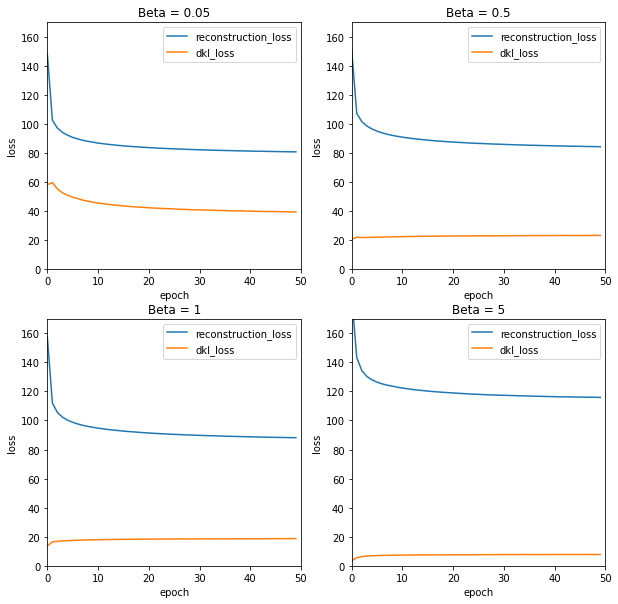

In [20]:
# plot results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(results[0][0], label='reconstruction_loss')
axs[0, 0].plot(results[0][1], label='dkl_loss')
axs[0, 0].set_title(f'Beta = {betas[0]}')

axs[0, 1].plot(results[1][0], label='reconstruction_loss')
axs[0, 1].plot(results[1][1], label='dkl_loss')
axs[0, 1].set_title(f'Beta = {betas[1]}')

axs[1, 0].plot(results[2][0], label='reconstruction_loss')
axs[1, 0].plot(results[2][1], label='dkl_loss')
axs[1, 0].set_title(f'Beta = {betas[2]}')

axs[1, 1].plot(results[3][0], label='reconstruction_loss')
axs[1, 1].plot(results[3][1], label='dkl_loss')
axs[1, 1].set_title(f'Beta = {betas[3]}')


for ax in axs.flat:
    ax.set(xlabel='epoch', ylabel='loss')
    ax.legend()
    ax.set_xlim(0,50)
    ax.set_ylim(0, 170)


In [ ]:
def display_model_results(model_path ,num_images=5):
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae.load_state_dict(torch.load(model_path))
    vae.eval()

    with torch.no_grad():
        vae_samples = vae.sample(num_samples=num_images).view(num_images, 28, 28).data.cpu().numpy()
        fig = plt.figure(figsize=(8 ,5))
        for i in range(num_images):
            ax = fig.add_subplot(2, 3, i + 1)
            ax.imshow(vae_samples[i], cmap='gray')
            ax.set_axis_off()

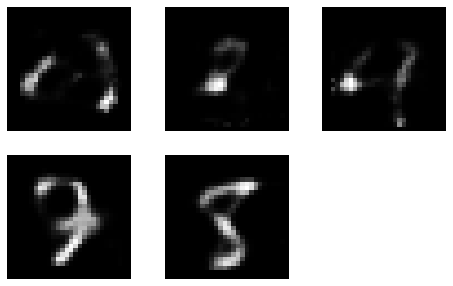

In [38]:
display_model_results("checkpoints/beta_0.05_final.pth")

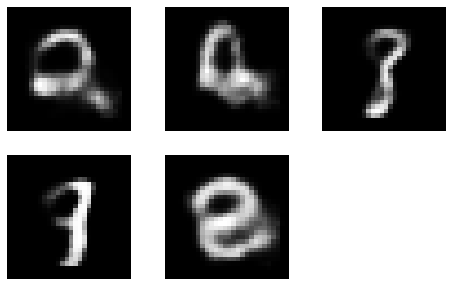

In [23]:
display_model_results("checkpoints/beta_0.5_final.pth")

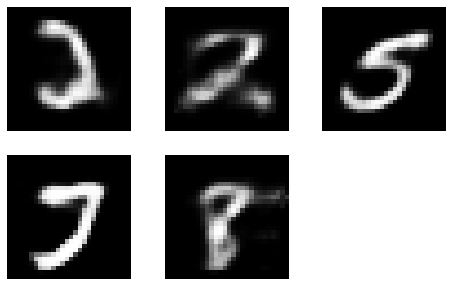

In [24]:
display_model_results("checkpoints/beta_1_final.pth")

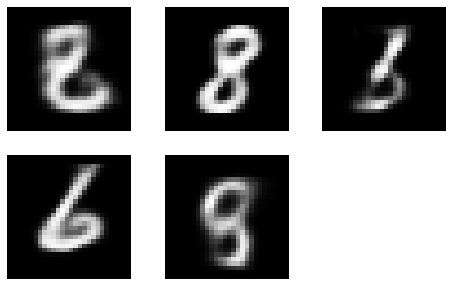

In [29]:
display_model_results("checkpoints/beta_5_final.pth")

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 1 - $\beta$-VAE
---
We will now analyze the results. Answer the following questions:
1. Explain intuitively the loss function of $\beta$-VAE. In your answer, explain the trade-off between the reconstruction loss and the KL-divergence and how it is affected by the $\beta$ parameter. Hint: think about regularization as you learned in the ML course (for example, in linear regression).
2. What is the main trend in the KL and reconstruction loss vs. epochs? In your answer, you should compare between the $\beta$'s.
3. For what values of $\beta$ you would expect better reconstruction (why would we want better reconstruction?) and for what values you would expect higher-quality samples? In your answer, refer to the blurriness in the samples you plotted.
4. Run the cell where you plot the samples (if you separated the cells for each $\beta$, then run all of them) a couple of times (just hit Ctrl + Enter). For which value of $\beta$ there is more *diversity* in the samples? (i.e., if out of 6 samples you get four 9's, it is not diverse).

# Q1 Answers:

## 1
The loss is a weighted sum of the:
 - reconstruction error : how similar the output image is to the input
 - KL divergence : how much the distribution of the latent space is different from the prior

We would like to minimize the first one in order for the vae to learn to reconstruct the input, and minimize the second one in order to make the latent space as close as possible to the prior, a.k.a isotropic gaussian.
The KL divergence can be seen as a regularization term for the reconstruction loss which is the actual loss function.

The $\beta$ parameter is used to control the trade-off between the reconstruction loss and the KL divergence.

## 2
Both parts of the losses should be decreasing with the number of epochs, as the optimizer tries to optimize them both, but higher betas make the KL term in the loss more important as it takes larger part of the overall loss. Lower betas makes the reconstruction loss more important as it takes more part of the overall loss.
The higher weight for either parts of the loss, the faster this part decays.

In practice, the KL term is not really descending, it is almost flat.

## 3
For better reconstruction, we, of course, want to give higher weight to the reconstruction loss, which means we want lower beta. We want better reconstruction of the train set, to verify that the model learned the correct distribution of the data, so it will be able to generate similar samples.
For better image quality, we would like higher values of beta, because when we sample, we assume that the distribution of the latent space is close to the prior, if this is not correct, we would sample too far from the distribution of the latent space.
We can indeed see that for higher betas, the images are sharper, because the model managed to make the distribution of z close to the prior (normal).

## 4
The higher the beta, the less weight for the reconstruction loss, which means we have lower reconstruction loss and the model learns to imitate the images it was trained on, this is why we get less diverse results for low beta.


### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 2 - Conditional VAE (CVAE)
---
Conditional Variational Autoencoder (CVAE) is an extension of Variational Autoencoder (VAE).
However, as you may have noticed, we have no control on the data generation process on VAE. That is, for example, on MNIST, we could not control the latent space, and when we sampled, we would not know what digit would be generated. This could be problematic if we want to generate some specific data. As an example, suppose we want to convert a unicode character to handwriting. In vanilla VAE, there is no way to generate the handwriting based on the character that the user inputted. Concretely, suppose the user inputted character ‘2’, how do we generate handwriting image that is a character ‘2’? We couldn’t.

Hence, CVAE was developed. Whereas VAE essentially models latent variables and data directly, CVAE models lantent variables and data, both conditioned to some random variables.
Recall, on VAE, the objective is:
$$\log P(X) -  D_{KL}[Q(z|X) || P(z|X)]  =  \mathbb{E}_{Q(z|X)}[\log P(X|z)] -D_{KL}[Q(z|X)|| P(z)]  $$
that is, we want to optimize the log likelihood of our data $P(X)$ under some “encoding” error. The original VAE model has two parts: the encoder $Q(x|Z)$ and the decoder $P(X|z)$.

If we focus on the encoder, it models the latent variable $z$ directly based on $X$, and it doesn't care about the different types of $X$ (e.g., it doesn't care if it is 1 or an 8). But wait, this was all the idea of **unsupervised learning**, we have no access to labels. Well, in this case, we have some information (thus, CVAE is sometimes referred to as **semi-supervised** learning model).

Similarly, in the decoder part, it only models $X$ directly based on the latent variable $z$. So, how do we tell the VAE what we want to generate? We can condition encoder and decoder to another things, let's denote them with $c$ (for "condition").

* The encoder is now conditioned on 2 variables- $X, c$: $Q(z|X,c)$ and the decoder in now conditioned on- $z$, $c$: $P(X|z,c)$
* Hence, our variational lower bound objective is now in this following form: $$ \log P(X|c) -  D_{KL}[Q(z|X,c) || P(z|X,c)]  =  \mathbb{E}_{Q(z|X,c)}[\log P(X|z,c)] -D_{KL}[Q(z|X,c)|| P(z|c)] $$ (we just conditioned all of the distributions with a variable $c$)
* So what is different? Almost nothing! We still model $P(z|c) \sim \mathcal{N}(0,I)$, and the rest are modeled by the neural network.
* But how is it done in practice? Simple! **Concatenation**: instead of encoding $X$, we encoded $[X,c]$, that is, we concatenate them. Same for the decoder: we take the latent variable $z$ and concatenate with $c$ and then the input of the decoder is $[z,c]$.
* In PyTorch, we concatenate with `x = torch.cat([x, x_cond], dim=1)` (the 0 dimension is the batch dimension).

The tasks:
* Load the Fashion-MNIST dataset, as in the tuorial, and create a train loader. Note that you get both the images and their **labels**.
* The labels are the classes (0-9). In order to use them in the network we need to convert them to one-hot vectors (0 -> [1,0,0,0,0,0,0,0,0,0], 1 -> [0,1,0,0,0,0,0,0,0,0] ...). The length of the one hot vector in as the number of classes. You are given a function that converts ints to one-hot vectors, use it on the labels, before you perform the concatenation.
* Modify the VAE architecture to support conditionals.
    * Copy-paste the skeleton (the original VAE, from the begining of the tutorial), and just modify the current functions. Note that there **are very few** changes needed.
    * Here are some tips, but feel free to implement as you wish, as long as it works:
        * In Python, you can let a function input be `None`, and then if the user inputs something that is not `None`, the function would act different. Here is an example: `def encode(x, x_cond=None): if x_cond is not None: ...`
        * Here are the parts that we recommend you change:
            * In the Vae module:
                * `def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu"), cond_dim=None)`
                * `def sample(self, num_samples=1, x_cond=None)`
                * `def forward(self, x, x_cond=None)`
            * Note that these are the minimal changes that can be done to implement VAE that supports CVAE. No need to modify VaeEncoder and VaeDecoder when we are using fully-connected layers. However, if we were to use convolutional layers, we would have to change also the encoder and decoder since convolutional layers work on images, and only after the images features from the convolutional layers have been extracted, we would concatenate the the condional $c$ (just before the fully-connected layers that output $\mu, \sigma$.
* Train CVAE on the Fashion-MNIST dataset (100 epochs, at least). Use $\beta$-VAE loss function (it shouldn't have changed from the regular VAE. Save a checkpoint of the network in the format: `fmnist_beta_(value of beta)_cvae_(number of epochs)_epochs.pth`. The rest of the hyper-parameters are up to you.
* Plot $n_{samples}=6$ from the CVAE for 6 classes of your choosing.
* **Tip**: this may take a while, so if everything seems to work, let it run on Google Colab and go grab another coffee.

In [17]:
def labels_to_one_hots(batch, num_classes=10):
    """
    Converts batch of integes numbers to one-hot vector given the vector length
    :param batch: batch of values to convert
    :param num_classes: length of the vector
    :return: one_hot_batch
    """
    one_hot_batch = torch.zeros(batch.size(0), num_classes).to(batch.device)
    for i in range(batch.size(0)):
        one_hot_batch[i, int(batch[i].data.cpu().item())] = 1
    return one_hot_batch

In [40]:
fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root='./datasets/',
                                                          train=True,
                                                          download=True,
                                                          transform=torchvision.transforms.ToTensor())

fmnist_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            drop_last=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST\raw



In [59]:
class CVae(torch.nn.Module):
    def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu"), cond_dim=None):
        super(CVae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        if cond_dim is None:
            cond_dim = 0

        self.encoder = VaeEncoder(x_dim + cond_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim + cond_dim)

    def encode(self, x):
        z, mu, logvar = self.encoder(x)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x

    def sample(self, num_samples=1, x_cond=None):
        """
        x_cond is expected to be a one-hot vector of length cond_dim with one dimension
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        if x_cond is not None:
            z = torch.cat([z, x_cond.broadcast_to(z.shape)], dim=1)
        return self.decode(z)

    def forward(self, x, x_cond=None):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        if x_cond is not None:
            x = torch.cat([x, x_cond], dim=1)

        z, mu, logvar = self.encode(x)

        if x_cond is not None:
            z = torch.cat([z, x_cond], dim=1)

        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

In [90]:
def train_conditional_vae(cvae, dataloader, vae_optim, num_epochs=100, beta=1, checkpoint_freq=5):
    losses = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        batch_losses = []
        for batch_i, batch in enumerate(dataloader):
            # forward pass
            x = batch[0].to(device).view(-1, X_DIM) # just the images
            x_recon, mu, logvar, z = cvae(x, x_cond=labels_to_one_hots(batch[1].to(device), 10).to(device))
            _, _, loss = beta_loss_function(x_recon, x, mu, logvar, beta=beta)

            # optimization
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()

            batch_losses.append(loss.data.cpu().numpy())

            # save checkpoint:

        losses.append(np.mean(batch_losses))

        if epoch % checkpoint_freq == 0:
            fname = f"./checkpoints_cvae/beta_{beta}_cvae_{epoch}_epochs.pth"
            torch.save(cvae.state_dict(), fname)
            print("saved checkpoint @", fname)

        print(f"epoch: {epoch} loss: {losses[-1] :.5f} | epoch time: {time.time() - epoch_start_time:.3f} sec")

    # save final model:
    fname = f"./checkpoints_cvae/beta_{beta}_cvae_final.pth"
    torch.save(cvae.state_dict(), fname)
    print("saved final model @", fname)

    return losses

In [95]:
cvae = CVae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device, cond_dim=10).to(device)
cvae_optim = torch.optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

losses = train_conditional_vae(cvae, fmnist_loader, cvae_optim, num_epochs=100, beta=1.5)


saved checkpoint @ ./checkpoints_cvae/beta_1.5_cvae_0_epochs.pth
epoch: 0 loss: 290.76035 | epoch time: 16.437 sec
epoch: 1 loss: 259.47610 | epoch time: 14.342 sec
epoch: 2 loss: 254.42549 | epoch time: 14.392 sec
epoch: 3 loss: 251.68060 | epoch time: 14.409 sec
epoch: 4 loss: 249.85989 | epoch time: 15.021 sec
saved checkpoint @ ./checkpoints_cvae/beta_1.5_cvae_5_epochs.pth
epoch: 5 loss: 248.67979 | epoch time: 14.424 sec
epoch: 6 loss: 247.65358 | epoch time: 13.700 sec
epoch: 7 loss: 246.85336 | epoch time: 13.325 sec
epoch: 8 loss: 246.18674 | epoch time: 13.770 sec
epoch: 9 loss: 245.72269 | epoch time: 14.656 sec
saved checkpoint @ ./checkpoints_cvae/beta_1.5_cvae_10_epochs.pth
epoch: 10 loss: 245.19975 | epoch time: 14.527 sec
epoch: 11 loss: 244.91794 | epoch time: 15.456 sec
epoch: 12 loss: 244.52162 | epoch time: 13.869 sec
epoch: 13 loss: 244.24283 | epoch time: 13.362 sec
epoch: 14 loss: 244.00919 | epoch time: 13.542 sec
saved checkpoint @ ./checkpoints_cvae/beta_1.5_cv

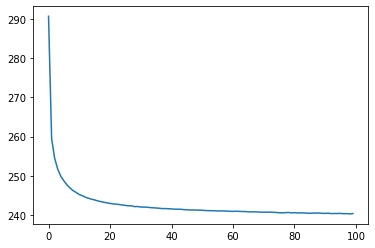

In [96]:
# plot losses:
plt.plot(losses)

In [100]:
cvae = CVae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device, cond_dim=10).to(device)
cvae.load_state_dict(torch.load("./checkpoints_cvae/beta_1.5_cvae_final.pth"))
cvae.eval()

CVae(
  (encoder): VaeEncoder(
    (features): Sequential(
      (0): Linear(in_features=794, out_features=256, bias=True)
      (1): ReLU()
    )
    (fc1): Linear(in_features=256, out_features=10, bias=True)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): VaeDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [18]:
def generate_items(cvae, item_id, num_images=6):
    with torch.no_grad():
        x_cond = labels_to_one_hots(torch.tensor([item_id]), 10).to(device)
        cvae_samples = cvae.sample(num_samples=num_images, x_cond=x_cond).view(num_images, 28, 28).data.cpu().numpy()
        fig = plt.figure(figsize=(8 ,5))
        for i in range(num_images):
            ax = fig.add_subplot(2, 3, i + 1)
            ax.imshow(cvae_samples[i], cmap='gray')
            ax.set_axis_off()

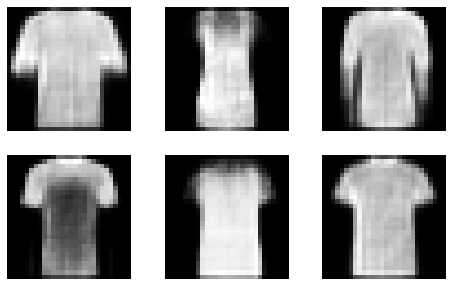

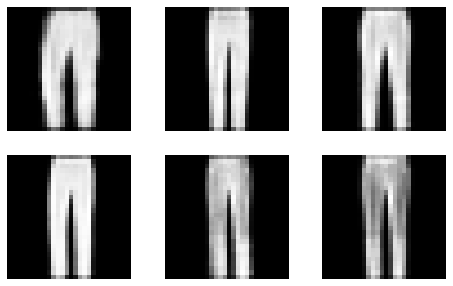

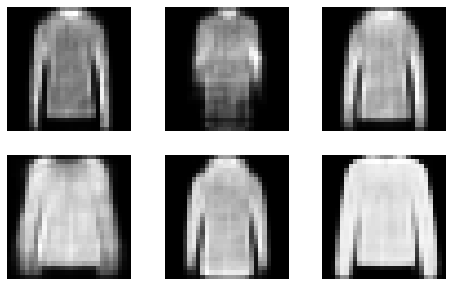

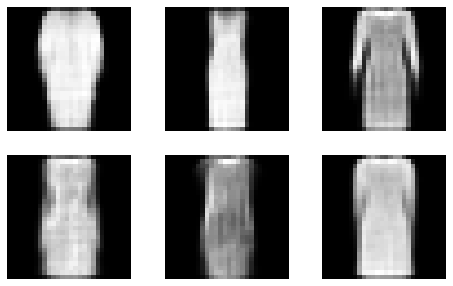

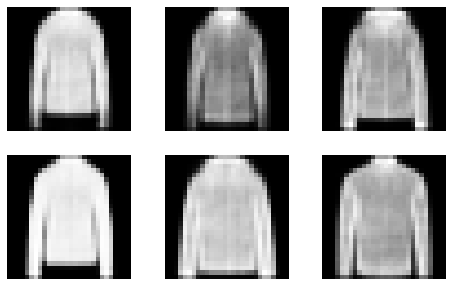

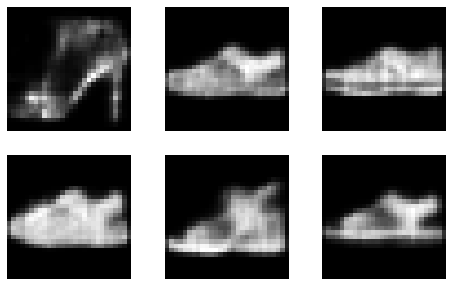

In [106]:
for i in range(6):
    generate_items(cvae, i)

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 2 - Conditional VAE
---
1. Can we perform interpolation of the latent space as we did in the tutorial? What is the meaning of doing **in-class** interpolation in the case of Fashion-MNIST? Explain.
2. Why did we convert the the classes number to one-hot vectors? Think of the other inputs to the networks and the values that the neurons accept. What is the risk of using just one number as the condition instead of a vector?
3. How is the quality of the samples? How can the quality be improved? In you answer, refer to the bluriness in the samples.

# Q2 Answers:

## 1
Yes, we can perform interpolation of the latent space as we did in the tutorial. If we want to perform in-class interpolation, we should interpolate between the two vectors only in the elements that are not conditional since the conditional elements are fixed. The meaning of doing that is that we will get different objects from the same class through out the interpolation.

## 2
Neurons expect to get a continuous value in each element while the classes label is a categorical variable. That means that for example, class *i* is not necessarily closer to class *i+1* than class *i+2* because their order is arbitrary, and neurons are not able to learn this relationship.
In addition, it is generally recommended to use values that are normalized to [0, 1] (or [-1, 1], but not [0, 9]) in a neural network input to avoid problems such as vanishing/exploding gradients. By using one-hot we avoid inputting values like *9*.
By putting one number, there is a risk that classes with close labels id will get tangled in each other, and we may also see instability in the training since we are having non - normalized vectors.

## 3
The quality of the images looks not bad but also not as good as the original images. The blurriness can be improved by choosing higher beta, and this is actually what we did, we used $\beta = 1.5$.
In addition, the image can be improved by improving the model like in any machine learning problem: adding more data, changing the architecture to be more complex, and etc...
of course this kind of improvements will cost us in computation time and work.


### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 2 - BONUS - Pokemon: Gotta Generate 'Em All!
---
This is a **non-mandatory**, more challenging task. Come back here only if you are done with the rest of the exercise and want to take on a challenge.

* Note - you should pick one of the following:
    * Fully-connected - work with grayscale images (5 points)
    * Convolutional - work with RGB images (10 points)
* No matter what type of model you chose, you need to answer the bonus questions that follow the code.

In this task we are going to (try) generate new pokemons! Our dataset includes ~900 pokemons. Each sample is a 60x60 image and the type of the pokemon (18 classes). The type is already in one-hot form. If you have access to a GPU, we recommend trying the convolutional version of this task.

Let's look at the data, for the **fully-connected** version.

In [5]:
from pokemon_dataset import PokemonDataset
import cv2
poke_data = PokemonDataset(root='./data/pokemon', rgb=True)
sample_dataloader = DataLoader(poke_data, batch_size=6, shuffle=True, drop_last=True)

can you name these pokemons?


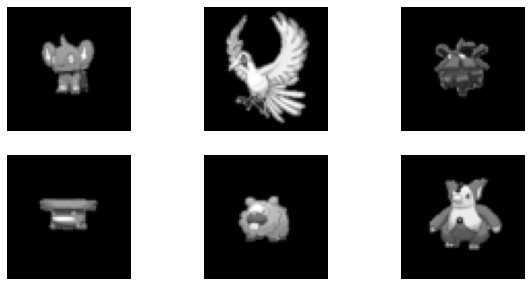

In [6]:
fig = plt.figure(figsize=(10 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i][0].data.cpu().numpy(), cmap="gray")
    ax.set_axis_off()
print("can you name these pokemons?")

In [7]:
# let's look at the types encoding
poke_data.type_to_one_hot

OrderedDict([('Bug',
              array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])),
             ('Dark',
              array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])),
             ('Dragon',
              array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])),
             ('Electric',
              array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])),
             ('Fairy',
              array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])),
             ('Fighting',
              array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])),
             ('Fire',
              array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])),
             ('Fl

**The task**: Implement CVAE for the pokemon dataset, it should not be different than the one you implemented for Fashion-MNIST. The task is to define the model and tune the hyper-parameters.
Note that due to being a really small dataset (only 900 examples!) you will need a really large number of epochs to get something. We don't expect to see actual pokemons, but we want to see the that the networks learned something. You will also need a larger latent space dimension, as pokemons are more complex than cloths.

* If you have taken the **Computer Vision** course - you should add **data augementations** to the images, to create a more diverse dataset. Recommended augmentations: `RandomHorizontalFlip`, `ColorJitter`, random horizontal translation (up to 5 pixels).



* Train CVAE on the pokemon dataset. Save a checkpoint once you are done: `pokemon_beta_(value of beta)_vae_(num epochs)_epochs.pth`.
* Plot samples for at least 6 types of your choosing (try to find the better ones).
* Plot reconstructions for at least 6 types of your choosing.

In [8]:
# your code here - you can use as many cells as you need

### Have access to a GPU and feel adventurous (CNN version)?
* If you have completed the fully-connected verion, you can just skip to the bonus questions.

If you feel creative and want to work with CNNs, we are giving you the VaeCnnEncoder and VaeCnnDecoder architectures, and all you have to do is implement the Vae class using these, and run the VAE with RGB images.
Let's look at the data.

can you name these pokemons?


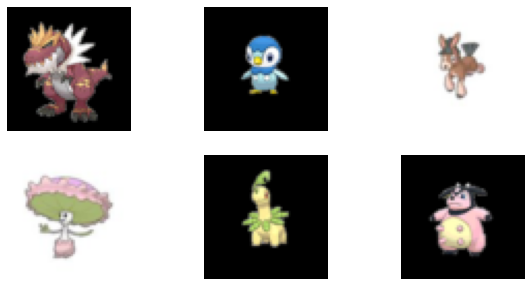

In [9]:
from pokemon_dataset import PokemonDataset
poke_data = PokemonDataset(root='./data/pokemon', rgb=True)
sample_dataloader = DataLoader(poke_data, batch_size=6, shuffle=True, drop_last=True)

fig = plt.figure(figsize=(10 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i].permute(1, 2, 0).data.cpu().numpy())  # permute to (Height, Width, Channels)
    ax.set_axis_off()
    
print("can you name these pokemons?")

### Your Turn
* Impelement the convolutional CVAE and train it. Save a checkpoint `"pokemon_cnn_beta_(value of beta)_vae_(num epochs)_epochs.pth"`
* Plot samples for at least 6 types of your choosing (try to find the better ones).
* Plot reconstructions for at least 6 types of your choosing.


* Note that the call to the loss function in the training loop is in the form: `loss = loss_function(x_recon, x.permute(0, 2, 3, 1), mu, logvar, loss_type='bce', beta=beta)`.
    * This is because `x_recon` is in the shape (batch_size, H, W, C) and `x` is (batch_size, C, H, W).
* Use a lower leraning rate (start with `1e-4`).

* Components:
    * Conv2D - `nn.Conv2d(in_channels, out_channels, kernel_size, stride)`
    * Deconv2d - `nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)`
    * Batch Normalization 1D - `nn.BatchNorm1d(num_features, affine=True)`
    * Batch Normalization 2D - `nn.BatchNorm2d(num_features, affine=True)`
    * Calculate the convolutional output size with `_get_conv_out(self, shape)` as in tutorial 8.
    * FC/Linear - `nn.Linear(in, out)`

#### Encoder Architecture - `VaeCnnEncoder(torch.nn.Module)`
* Block 1:
    * Conv2d - `in_channels=3, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - 128 features
    * ReLU (or any other activation you want)
* Block 2:
    * Conv2d - `in_channels=128, out_channels=64*4, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - $64*4$ features
    * ReLU (or any other activation you want)
* Block 3:
    * Conv2d - `in_channels=64*4, out_channels=64*8, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - $64*8$ features
    * ReLU (or any other activation you want)
* FC1 ($\mu$) - `nn.Linear(self._get_conv_out(x_shape) + self.cond_dim, self.z_dim)`
* FC1 ($\Sigma$) - `nn.Linear(self._get_conv_out(x_shape) + self.cond_dim, self.z_dim)`

#### Decoder Architecture - `VaeCnnDecoder(torch.nn.Module)`
* FC1 ($z$) - `nn.Linear(self.z_dim (+cond_dim), 64 * 4 * 4 * 4)`
* Batch Normalization 1D - $64*4*4*4$ features.
* Block 1:
    * Deconv2d - `in_channels=64 * 4, 64 * 2, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
    * Batch Normalization 2D - 128 features
    * ReLU (or any other activation you want)
* Block 2:
    * Deconv2d - `in_channels=128, 64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
    * Batch Normalization 2D - 64 features
    * ReLU (or any other activation you want)
* Block 3:
    * Deconv2d - `in_channels=64, 64, kernel_size=(3, 3), stride=(2, 2), padding=2, output_padding=1`
    * Batch Normalization 2D - 64 features
    * ReLU (or any other activation you want)
* Deconv2d - `in_channels=64, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
* Sigmoid



In [11]:
class VaeCnnEncoder(torch.nn.Module):
    def __init__(self, x_dim=(3, 60, 60), z_dim=128, cond_dim=18, device=torch.device("cpu")):
        super(VaeCnnEncoder, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.device = device

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=64*4, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64*4, out_channels=64*8, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(),
        )

        fc_input_dim = self._get_conv_out(x_dim) + cond_dim
        self.fc_mu = nn.Linear(fc_input_dim, self.z_dim, bias=True)
        self.fc_logvar = nn.Linear(fc_input_dim, self.z_dim, bias=True)


    def bottleneck(self, h):
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x, x_cond):
        """
        This is the function called when doing the forward pass:
        z, mu, logvar = VaeEncoder(X)
        """
        h = self.features(x)
        h = torch.flatten(h, start_dim=1)
        # make sure that shapes are ok here:
        h = torch.cat((h, x_cond), dim=1)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def _get_conv_out(self, shape):
        o = self.features(torch.zeros(1, *shape))
        return int(np.prod(o.size()))


class VaeCnnDecoder(torch.nn.Module):
    def __init__(self, x_dim=(3, 60, 60), z_dim=128, cond_dim=18, device=torch.device("cpu")):
        super(VaeCnnDecoder, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim

        self.linear = nn.Sequential(
            nn.Linear(self.z_dim + cond_dim, 64 * 4 * 4 * 4),
            nn.BatchNorm1d(64 * 4 * 4 * 4),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
             nn.ConvTranspose2d(in_channels=64 * 4, out_channels=64 * 2, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1),
             nn.BatchNorm2d(64 * 2),
             nn.LeakyReLU(),
             nn.ConvTranspose2d(in_channels=64 * 2, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1),
             nn.BatchNorm2d(64),
             nn.LeakyReLU(),
             nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=2, output_padding=1),
             nn.BatchNorm2d(64),
             nn.LeakyReLU(),
             nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1),
             nn.Sigmoid()
        )

    def forward(self, x, x_cond):
        x = torch.cat((x, x_cond), dim=1)
        x = self.linear(x).view(-1, 64*4, 4, 4)
        x = self.decoder(x)
        return x


class CnnCVae(torch.nn.Module):
    def __init__(self, x_dim=(3, 60, 60), z_dim=128, device=torch.device("cpu"), cond_dim=18):
        super(CnnCVae, self).__init__()
        self.device = device
        self.z_dim = z_dim
        self.cond_dim = cond_dim

        self.encoder = VaeCnnEncoder(x_dim, z_dim=z_dim, cond_dim=cond_dim, device=device)
        self.decoder = VaeCnnDecoder(x_dim, z_dim=z_dim, cond_dim=cond_dim, device=device)

    def encode(self, x, x_cond):
        z, mu, logvar = self.encoder(x, x_cond)
        return z, mu, logvar

    def decode(self, z, x_cond):
        x = self.decoder(z, x_cond)
        return x

    def sample(self, num_samples, x_cond):
        """
        x_cond is expected to be a one-hot vector of length cond_dim with one dimension
        (all samples are the same class)
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        x_cond = x_cond.repeat(z.shape[0], 1).to(self.device)
        return self.decode(z, x_cond)

    def forward(self, x, x_cond):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        z, mu, logvar = self.encode(x, x_cond)
        x_recon = self.decode(z, x_cond)

        return x_recon, mu, logvar, z

In [33]:
def train_pokemon_cvae(pokemon_cnn_cvae, dataloader, optim, num_epochs=100, beta=1, checkpoint_freq=10):
    losses = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        batch_losses = []
        for batch_i, batch in enumerate(dataloader):
            # forward pass
            x = batch[0].to(device)
            x_cond = batch[1].to(device)
            x_recon, mu, logvar, z = pokemon_cnn_cvae(x, x_cond=x_cond)
            _, _, loss = beta_loss_function(x_recon, x, mu, logvar, loss_type='bce', beta=beta)

            # optimization
            optim.zero_grad()
            loss.backward()
            optim.step()

            batch_losses.append(loss.data.cpu().numpy())

            # save checkpoint:

        losses.append(np.mean(batch_losses))

        if epoch % checkpoint_freq == 0:
            fname = f"./checkpoints_pokemon_cnn/{epoch}_epochs.pth"
            torch.save(pokemon_cnn_cvae.state_dict(), fname)
            print("saved checkpoint @", fname)

        print(f"epoch: {epoch} loss: {losses[-1] :.5f} | epoch time: {time.time() - epoch_start_time:.3f} sec")

    # save final model:
    fname = f"./checkpoints_pokemon_cnn/final.pth"
    torch.save(pokemon_cnn_cvae.state_dict(), fname)
    print("saved final model @", fname)

    return losses

In [13]:
BATCH_SIZE = 128
ZDIM = 256
NUM_EPOCHS = 1500
BETA = 2
LEARNING_RATE = 0.5e-4

In [35]:

cnn_cvae = CnnCVae(z_dim=ZDIM, device=device).to(device)
optim = torch.optim.Adam(cnn_cvae.parameters(), lr=LEARNING_RATE)
pokemon_dataloader = DataLoader(dataset=poke_data, batch_size=BATCH_SIZE, shuffle=True)

losses = train_pokemon_cvae(cnn_cvae, pokemon_dataloader, optim, num_epochs=NUM_EPOCHS, beta=BETA)

saved checkpoint @ ./checkpoints_pokemon_cnn/0_epochs.pth
epoch: 0 loss: 8617.10449 | epoch time: 2.466 sec
epoch: 1 loss: 8054.79688 | epoch time: 2.650 sec
epoch: 2 loss: 7597.12256 | epoch time: 2.267 sec
epoch: 3 loss: 7211.48877 | epoch time: 2.250 sec
epoch: 4 loss: 6890.40332 | epoch time: 2.293 sec
epoch: 5 loss: 6608.31885 | epoch time: 2.174 sec
epoch: 6 loss: 6367.60303 | epoch time: 2.335 sec
epoch: 7 loss: 6255.57520 | epoch time: 2.165 sec
epoch: 8 loss: 6074.29053 | epoch time: 2.334 sec
epoch: 9 loss: 5880.29150 | epoch time: 2.166 sec
saved checkpoint @ ./checkpoints_pokemon_cnn/10_epochs.pth
epoch: 10 loss: 5696.83301 | epoch time: 2.433 sec
epoch: 11 loss: 5581.30566 | epoch time: 2.267 sec
epoch: 12 loss: 5438.32422 | epoch time: 2.216 sec
epoch: 13 loss: 5352.09131 | epoch time: 2.273 sec
epoch: 14 loss: 5307.72168 | epoch time: 2.267 sec
epoch: 15 loss: 5175.01221 | epoch time: 2.177 sec
epoch: 16 loss: 5051.80811 | epoch time: 2.333 sec
epoch: 17 loss: 5001.96191

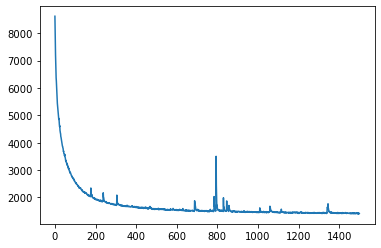

In [36]:
plt.plot(losses)

In [15]:
def generate_pokemons(model, poke_type, num_images=6):
    model.eval()
    with torch.no_grad():
        x_cond = labels_to_one_hots(torch.tensor([poke_type]), 18).to(device)
        model_samples = model.sample(num_samples=num_images, x_cond=x_cond).data.cpu().numpy()
        fig = plt.figure(figsize=(8 ,5))
        for i in range(num_images):
            ax = fig.add_subplot(2, 3, i + 1)
            ax.imshow(np.moveaxis(model_samples[i], 0, -1))
            ax.set_axis_off()

# 3 Generated pokemon of each class:
each line of 3 is different class

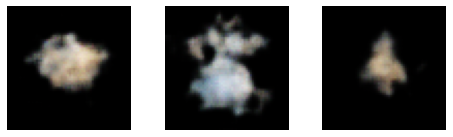

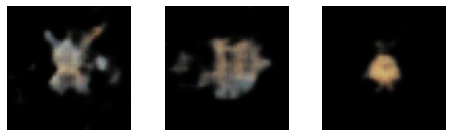

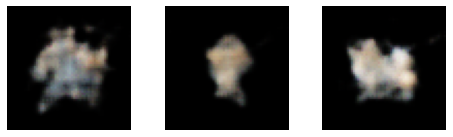

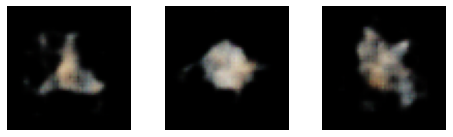

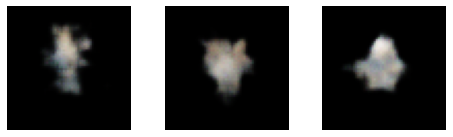

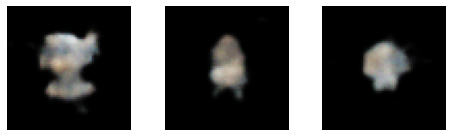

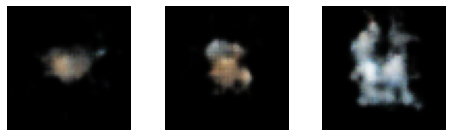

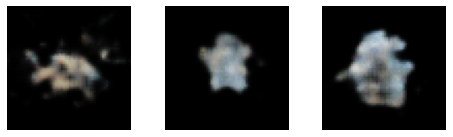

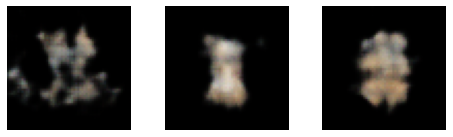

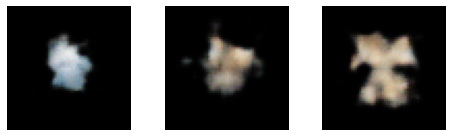

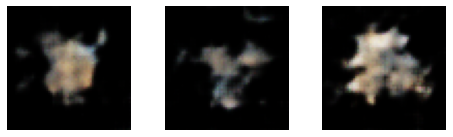

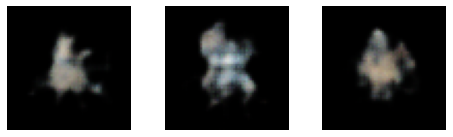

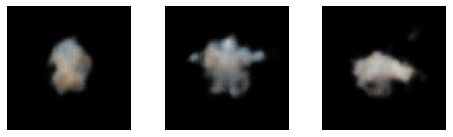

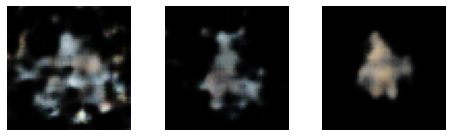

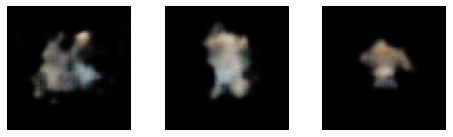

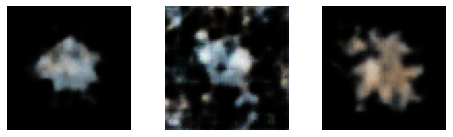

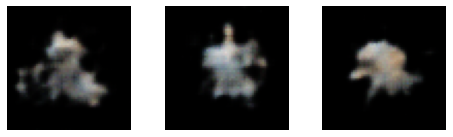

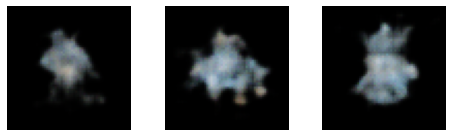

In [18]:
cnn_cvae = CnnCVae(z_dim=ZDIM, device=device).to(device)
cnn_cvae.load_state_dict(torch.load("./checkpoints_pokemon_cnn/final.pth"))

for i in range(18):
    generate_pokemons(cnn_cvae, i, num_images=3)

# Some reconstructions :

In [35]:
def reconstruct_pokemon(model, poke_type, original_image):
    model.eval()
    with torch.no_grad():
        im_recon, _, _, _ = model(original_image.unsqueeze(0), x_cond=poke_type.unsqueeze(0))
        im_recon = im_recon.data.cpu().numpy()[0]
        fig = plt.figure(figsize=(8 ,5))
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.moveaxis(original_image.data.cpu().numpy(), 0, -1))
        ax.set_axis_off()
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.moveaxis(im_recon, 0, -1))
        ax.set_axis_off()
    model.train()

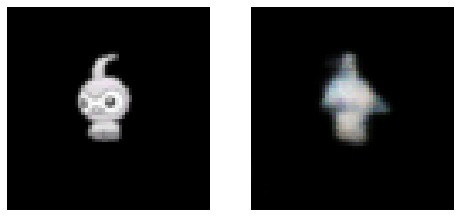

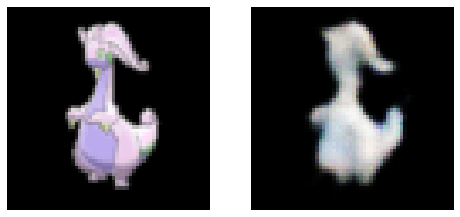

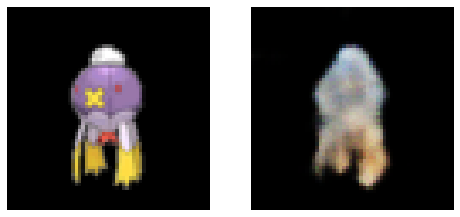

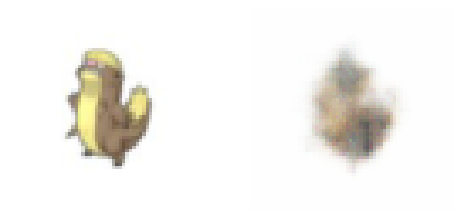

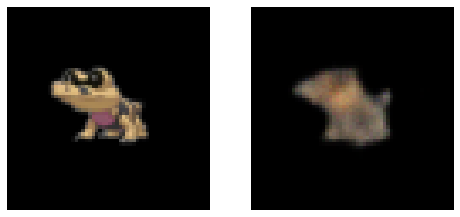

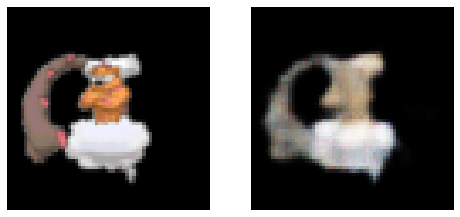

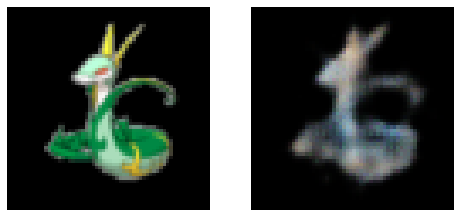

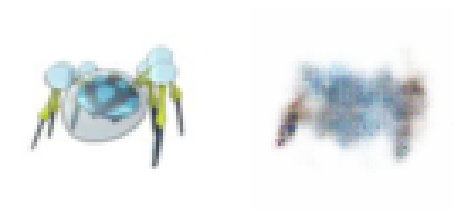

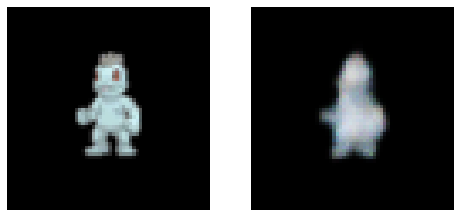

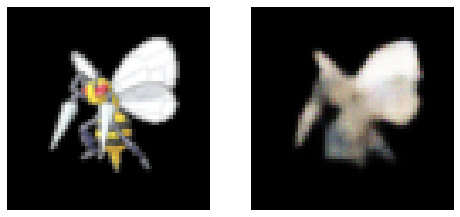

In [36]:
sample_dataloader = DataLoader(poke_data, batch_size=10, shuffle=True, drop_last=True)
images, labels = next(iter(sample_dataloader))

for image, label in zip(images, labels):
    image = image.to(device)
    label = label.to(device)
    reconstruct_pokemon(cnn_cvae, label, image)

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Bonus Question
---
1. What do you think about the results on the Pokemon dataset? Name at least 2 reasons for the VAE somewhat low performance on the Pokemon dataest.
2. Suggest ideas to improve the performance (at least 2).

# Bonus Question Answer

1. The results of the pokemon dataset are quite poor. The generated pokemons doesn't look like the original ones, it looks like some vague shapes, some of them remind pokemons but the color is usually just white. There are few possible reasons for this:
 - As mention in the instructions, the pokemons dataset is quite small for a VAE, and it is quite diverse. Pokemons are very different from each other even withing the same class. That makes their distribution hard to model as a Gaussian. In human faces or MNIST number, the samples in the dataset are quite similar withing the same class.
 - The reconstruction loss is L2, which is somewhat kind of an average over pixels. It means that the model tries to be better on average of all pixels, but it doesn't promise a good reconstruction and it ignores spatial information.

2. Some ideas:
 - use another reconstruction loss that uses spacial information like connection between pixels.
 - Use more complex model - more layers and etc...
 - Use more data, can be achived by data augmentation
 - Use more complex distribution in the latent space, maybe even a neural network to model it
 - Some how force the model to better learn connection between the color channels so the images will be more colorful

 ### <img src="https://img.icons8.com/cotton/64/000000/grand-master-key.png" style="height:50px;display:inline"> Part 2 - Clustering - Prologue
---
In this task we are going to explore Spectral Clustering for image segmentation. 
In computer vision, **image segmentation** is the process of partitioning a digital image into multiple segments (sets of pixels, also known as image objects). The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

We are going to compare K-Means to Spectral Clustering. Note that K-Means is also a step in the the spectral clustering algorithm.

In [37]:
# imports for the exrcise - part 2
# you can add more if you wish (but it is not really needed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

# sklearn imports
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering, KMeans

warnings.filterwarnings(category=UserWarning, action="ignore")

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 3 - Spectral Clustering Demonstration
---
Run the next code cell and answer (below the code cell) the following questions:
1. Run the cell 3 times (Ctrl + Enter). Why are the results different in each run? Hint: Spectral Clustering uses K-Means, and this is the root of the changes, but why? Why running K-Means several times gives different results?
2. The `image_to_graph` function builds a graph from the image. Explain how the graph is built (you can read the documentation of this function with `help(image.img_to_graph)`. What are the weights of edges?

total time: 3.701 sec


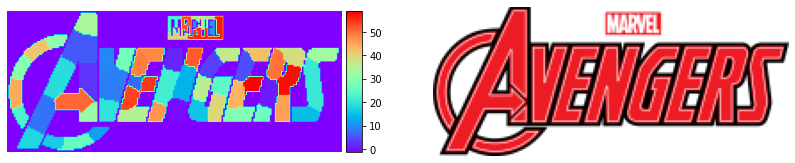

In [38]:
# run this cell
start_time = time.time()
original_img = Image.open("./data/a_logo_s.png")
grayscale_image = original_img.convert("L")  # convert to grayscale
img = np.array(grayscale_image)  # convert to np.array
img[img==255] = 0  # zero-out the background, we don't care about it
mask = img.astype(np.bool)  # create a mask for the graph-building function
img = img.astype(float) / 255  # convert to numbers in [0,1]
img += 1 / 255 + (0.2 / 255) * np.random.randn(*img.shape)  # add random noise to smooth the image

graph = image.img_to_graph(img, mask=mask)  # build a graph with the gradients as weights
graph.data = np.exp(-graph.data / graph.data.std())  # convert gradients to affinity

labels = spectral_clustering(graph, n_clusters=60, eigen_solver='arpack')  # run spectral clustering
label_im = np.full(mask.shape, -1.0)  # labels -> image
label_im[mask] = labels  # assign correct labels

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
imsh = ax1.imshow(label_im, cmap=plt.cm.rainbow)
ax1.set_axis_off()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(imsh, cax=cax)
ax2 = fig.add_subplot(122)
ax2.imshow(np.array(original_img))
ax2.set_axis_off()
print("total time: {:.3f} sec".format(time.time() - start_time))

# Answers:

 1. As mentioned in the question of spectral clustering's steps is preforming K-means algorithms, which is an algorithm that is strongly affected by initialization for convergence. Every single run the initialization of the cluster's centers is different and that causes different time for the algorithm to arrive at local maximum.
 2. The image to graph function constructs a graph from a given image such that the vertices are pixels and the edges are the gradients values. This function uses a ‘connectivity’ matrix, giving which samples(pixels) are connected.


### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 3 - Image Segmentation with Spectral Clustering & K-Means
---
1. Run K-Means on `a_logo_s.png`. Tune the number of clusters and number of iterations and plot the results in the same way as in the demonstration.
    * In order to use K-means on images, you need to reshape it: `img.reshape(-1,1)`
    * To run K-Means: create an instance of K-Means: `k_means = KMeans(n_clusters=, max_iter=)` and *fit* the reshaped img: `k_means.fit(...)`
    * To access the labels (=the assignment) of each pixel, call `labels = k_means.labels_`
2. Load `iron_man_p_s.png` and run K-Means and Spectral Clustering. Tune each algorithm's hyper-parameters (specifically, `n_clusters`). Plot the results.

total time: 4.565 sec


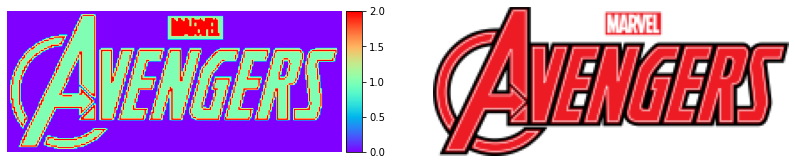

In [6]:
start_time = time.time()

original_img = Image.open("./data/a_logo_s.png")
grayscale_image = original_img.convert("L")
img = np.array(grayscale_image)

img_vec = img.reshape(-1,1)

k_means = KMeans(n_clusters=3, max_iter=200)
k_means.fit(img_vec)

img_segmented = k_means.labels_.reshape(img.shape)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
imsh = ax1.imshow(img_segmented, cmap=plt.cm.rainbow)
ax1.set_axis_off()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(imsh, cax=cax)
ax2 = fig.add_subplot(122)
ax2.imshow(np.array(original_img))
ax2.set_axis_off()
print("total time: {:.3f} sec".format(time.time() - start_time))

# Iron man:
## Spectral Clustering:

total time: 17.533 sec


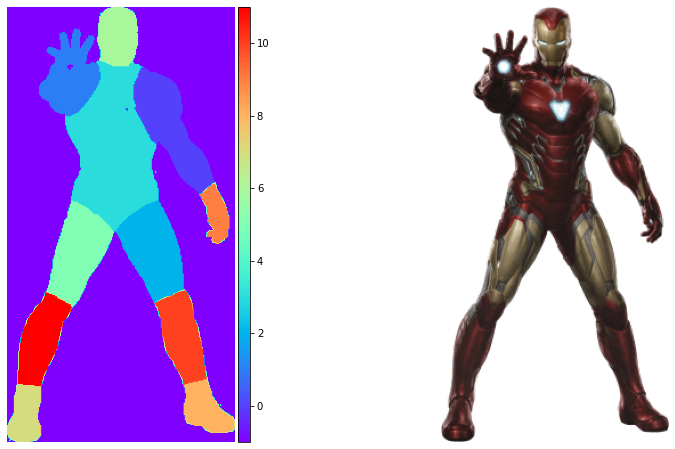

In [47]:
start_time = time.time()
original_img = Image.open("./data/iron_man_p_s.png")
grayscale_image = original_img.convert("L")  # convert to grayscale
img = np.array(grayscale_image)  # convert to np.array
img[img==255] = 0  # zero-out the background, we don't care about it
mask = img.astype(np.bool)  # create a mask for the graph-building function
img = img.astype(float) / 255  # convert to numbers in [0,1]
img += 1 / 255 + (0.2 / 255) * np.random.randn(*img.shape)  # add random noise to smooth the image

graph = image.img_to_graph(img, mask=mask)  # build a graph with the gradients as weights
graph.data = np.exp(-graph.data / graph.data.std())  # convert gradients to affinity

labels = spectral_clustering(graph, n_clusters=12, eigen_solver='arpack')  # run spectral clustering
label_im = np.full(mask.shape, -1.0)  # labels -> image
label_im[mask] = labels  # assign correct labels

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
imsh = ax1.imshow(label_im, cmap=plt.cm.rainbow)
ax1.set_axis_off()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(imsh, cax=cax)
ax2 = fig.add_subplot(122)
ax2.imshow(np.array(original_img))
ax2.set_axis_off()
print("total time: {:.3f} sec".format(time.time() - start_time))

# K-means:

total time: 0.500 sec


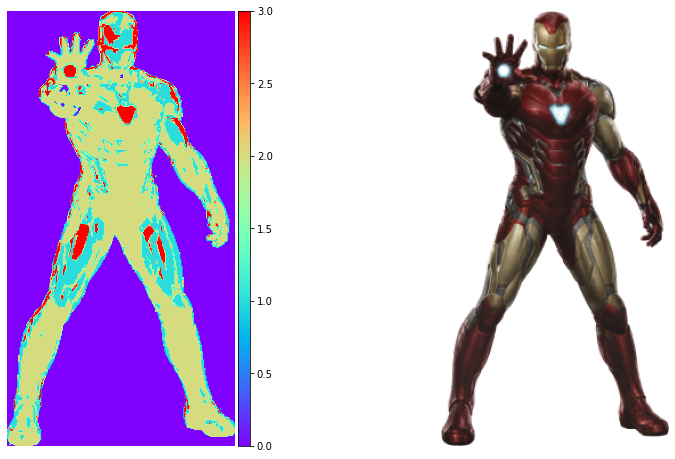

In [46]:
start_time = time.time()

original_img = Image.open("./data/iron_man_p_s.png")
grayscale_image = original_img.convert("L")
img = np.array(grayscale_image)

img_vec = img.reshape(-1,1)

k_means = KMeans(n_clusters=4, max_iter=5000)
k_means.fit(img_vec)

img_segmented = k_means.labels_.reshape(img.shape)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
imsh = ax1.imshow(img_segmented, cmap=plt.cm.rainbow)
ax1.set_axis_off()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(imsh, cax=cax)
ax2 = fig.add_subplot(122)
ax2.imshow(np.array(original_img))
ax2.set_axis_off()
print("total time: {:.3f} sec".format(time.time() - start_time))

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 4 - Image Segmentation with Spectral Clustering & K-Means
---
1. Compare the results of K-Means and Spectral Clustering on the Avengers logo. Which algoirthm yields more satisfying results, in your opinion? Explain.
2. Compare the results of K-Means and Spectral Clustering on Iron Man. Explain how did you tune the parameters (i.e., how did you pick the number of clusters). What is the difference between the Avengers logo and Iron Man?
3. Summarize the advantages and disadvantages of K-Means and Spectral Clustering for image segmentation (running time, type of images, amount of tuning...)

# Question 4 Answers
1. With spectral clustering, we can see better separation of areas, and if we had used fewer clusters, it might have separated the letters, which is good. With K-means, it didn't separate the letters but it did separate different colors. since the image is builed of just a few colors for the letters, edges and the background, it segmented the image to these classes. In our opinion the spectral clustering looks better, and it performed a harder task for this image - which is separating letters.
2. Spectral clustering segmented well different organs of his body (hands, legs, etc.) and K-means segmented parts with similar brightness. While spectral clustering was almost perfect for it's task, K-means result is noisy and it looks worse. In order to tune the parameters we tried to estimate how many segments are in the image. for K-means we tried to count how much different colors are in the image and for Spectral clustering we tried to figure out  to which part the body of Iron Man can be separated. The difference from the logo, is that the Iron Man image has more colors and brightness levels, which makes it hard to cluster while ignoring spatial connection between pixels
3 .
### Spectral Clustering Advantages Over K-means
* Takes into account the edges of the image, which makes sense for segmentation
* Takes into account spatial connection between pixels, which makes sense for segmenting different objects that are in different parts of the image
* Yields better results on most cases

### K-means Advantages Over Spectral Clustering
* Much faster since it doesn't require building a graph and etc...
* Requires tunning only K and not other parameters such as number of neighbors
* better for images with less colors


## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/